In [2]:
import pandas as pd

# Load the dataset
file_path = "E:\\Downloads\\student_depression_dataset.csv"
df = pd.read_csv(file_path)

# Display basic info and the first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

(None,
    id  Gender   Age           City Profession  Academic Pressure  \
 0   2    Male  33.0  Visakhapatnam    Student                5.0   
 1   8  Female  24.0      Bangalore    Student                2.0   
 2  26    Male  31.0       Srinagar    Student                3.0   
 3  30  Female  28.0       Varanasi    Student                3.0   
 4  32  Female  25.0         Jaipur    Student                4.0   
 
    Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
 0            0.0  8.97                 2.0               0.0   
 1            0.0  5.90                 5.0               0.0   
 2            0.0  7.03                 5.0               0.0   
 3            0.0  5.59                 2.0               0.0   
 4            0.0  8.13                 3.0               0.0   
 
         Sleep Duration Dietary Habits   Degree  \
 0          '5-6 hours'        Healthy  B.Pharm   
 1          '5-6 hours'       Moderate      BSc   
 2  'Less than 5 hours'        H

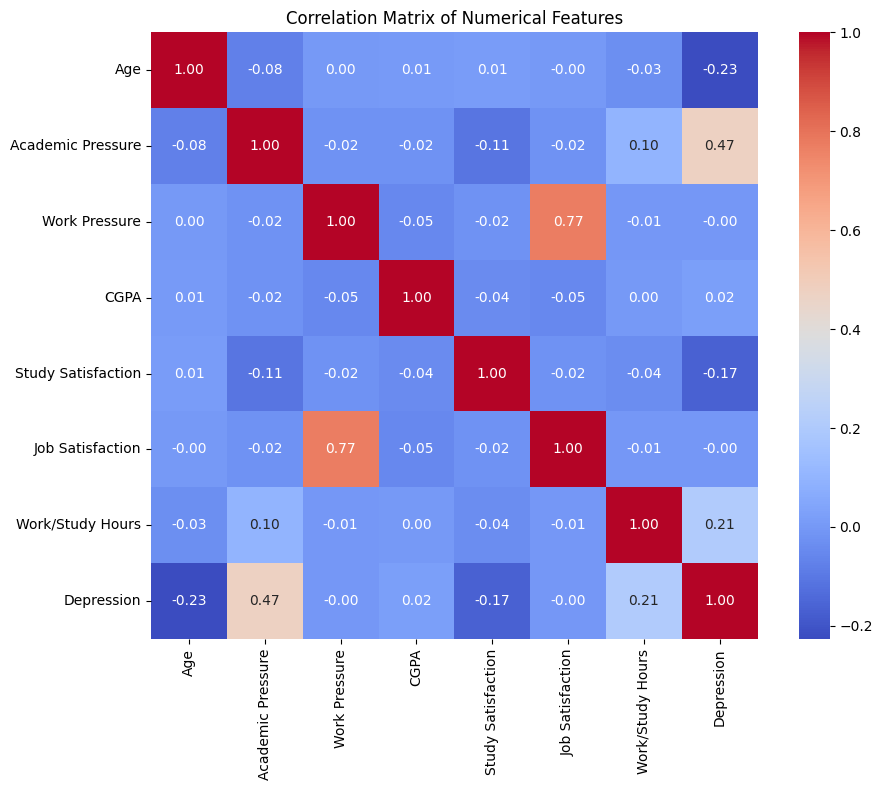

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation matrix
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Drop the 'id' column for correlation (not useful for modeling)
numerical_df = numerical_df.drop(columns=['id'])

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


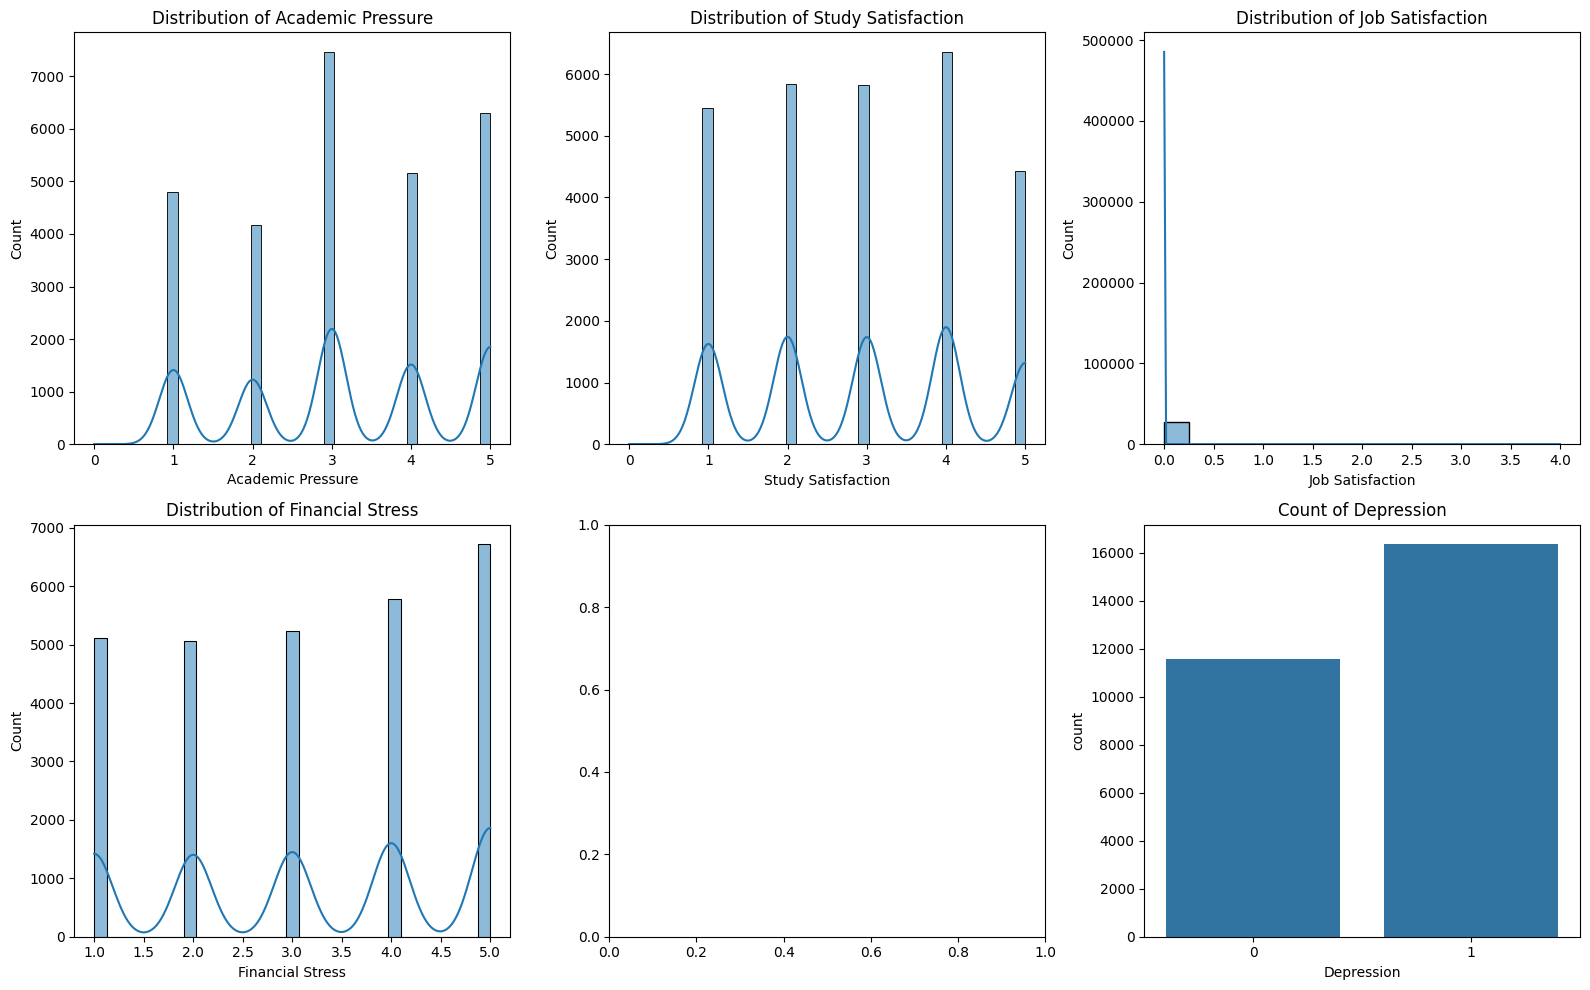

In [4]:
# Set of features to explore based on correlation and intuition
features_to_plot = ['Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress', 'Depression']

# Convert 'Financial Stress' to numeric for plotting (if needed)
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors='coerce')

# Plot distributions of selected features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot[:-1]):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Plot count of Depression
sns.countplot(data=df, x='Depression', ax=axes[-1])
axes[-1].set_title('Count of Depression')

plt.tight_layout()
plt.show()


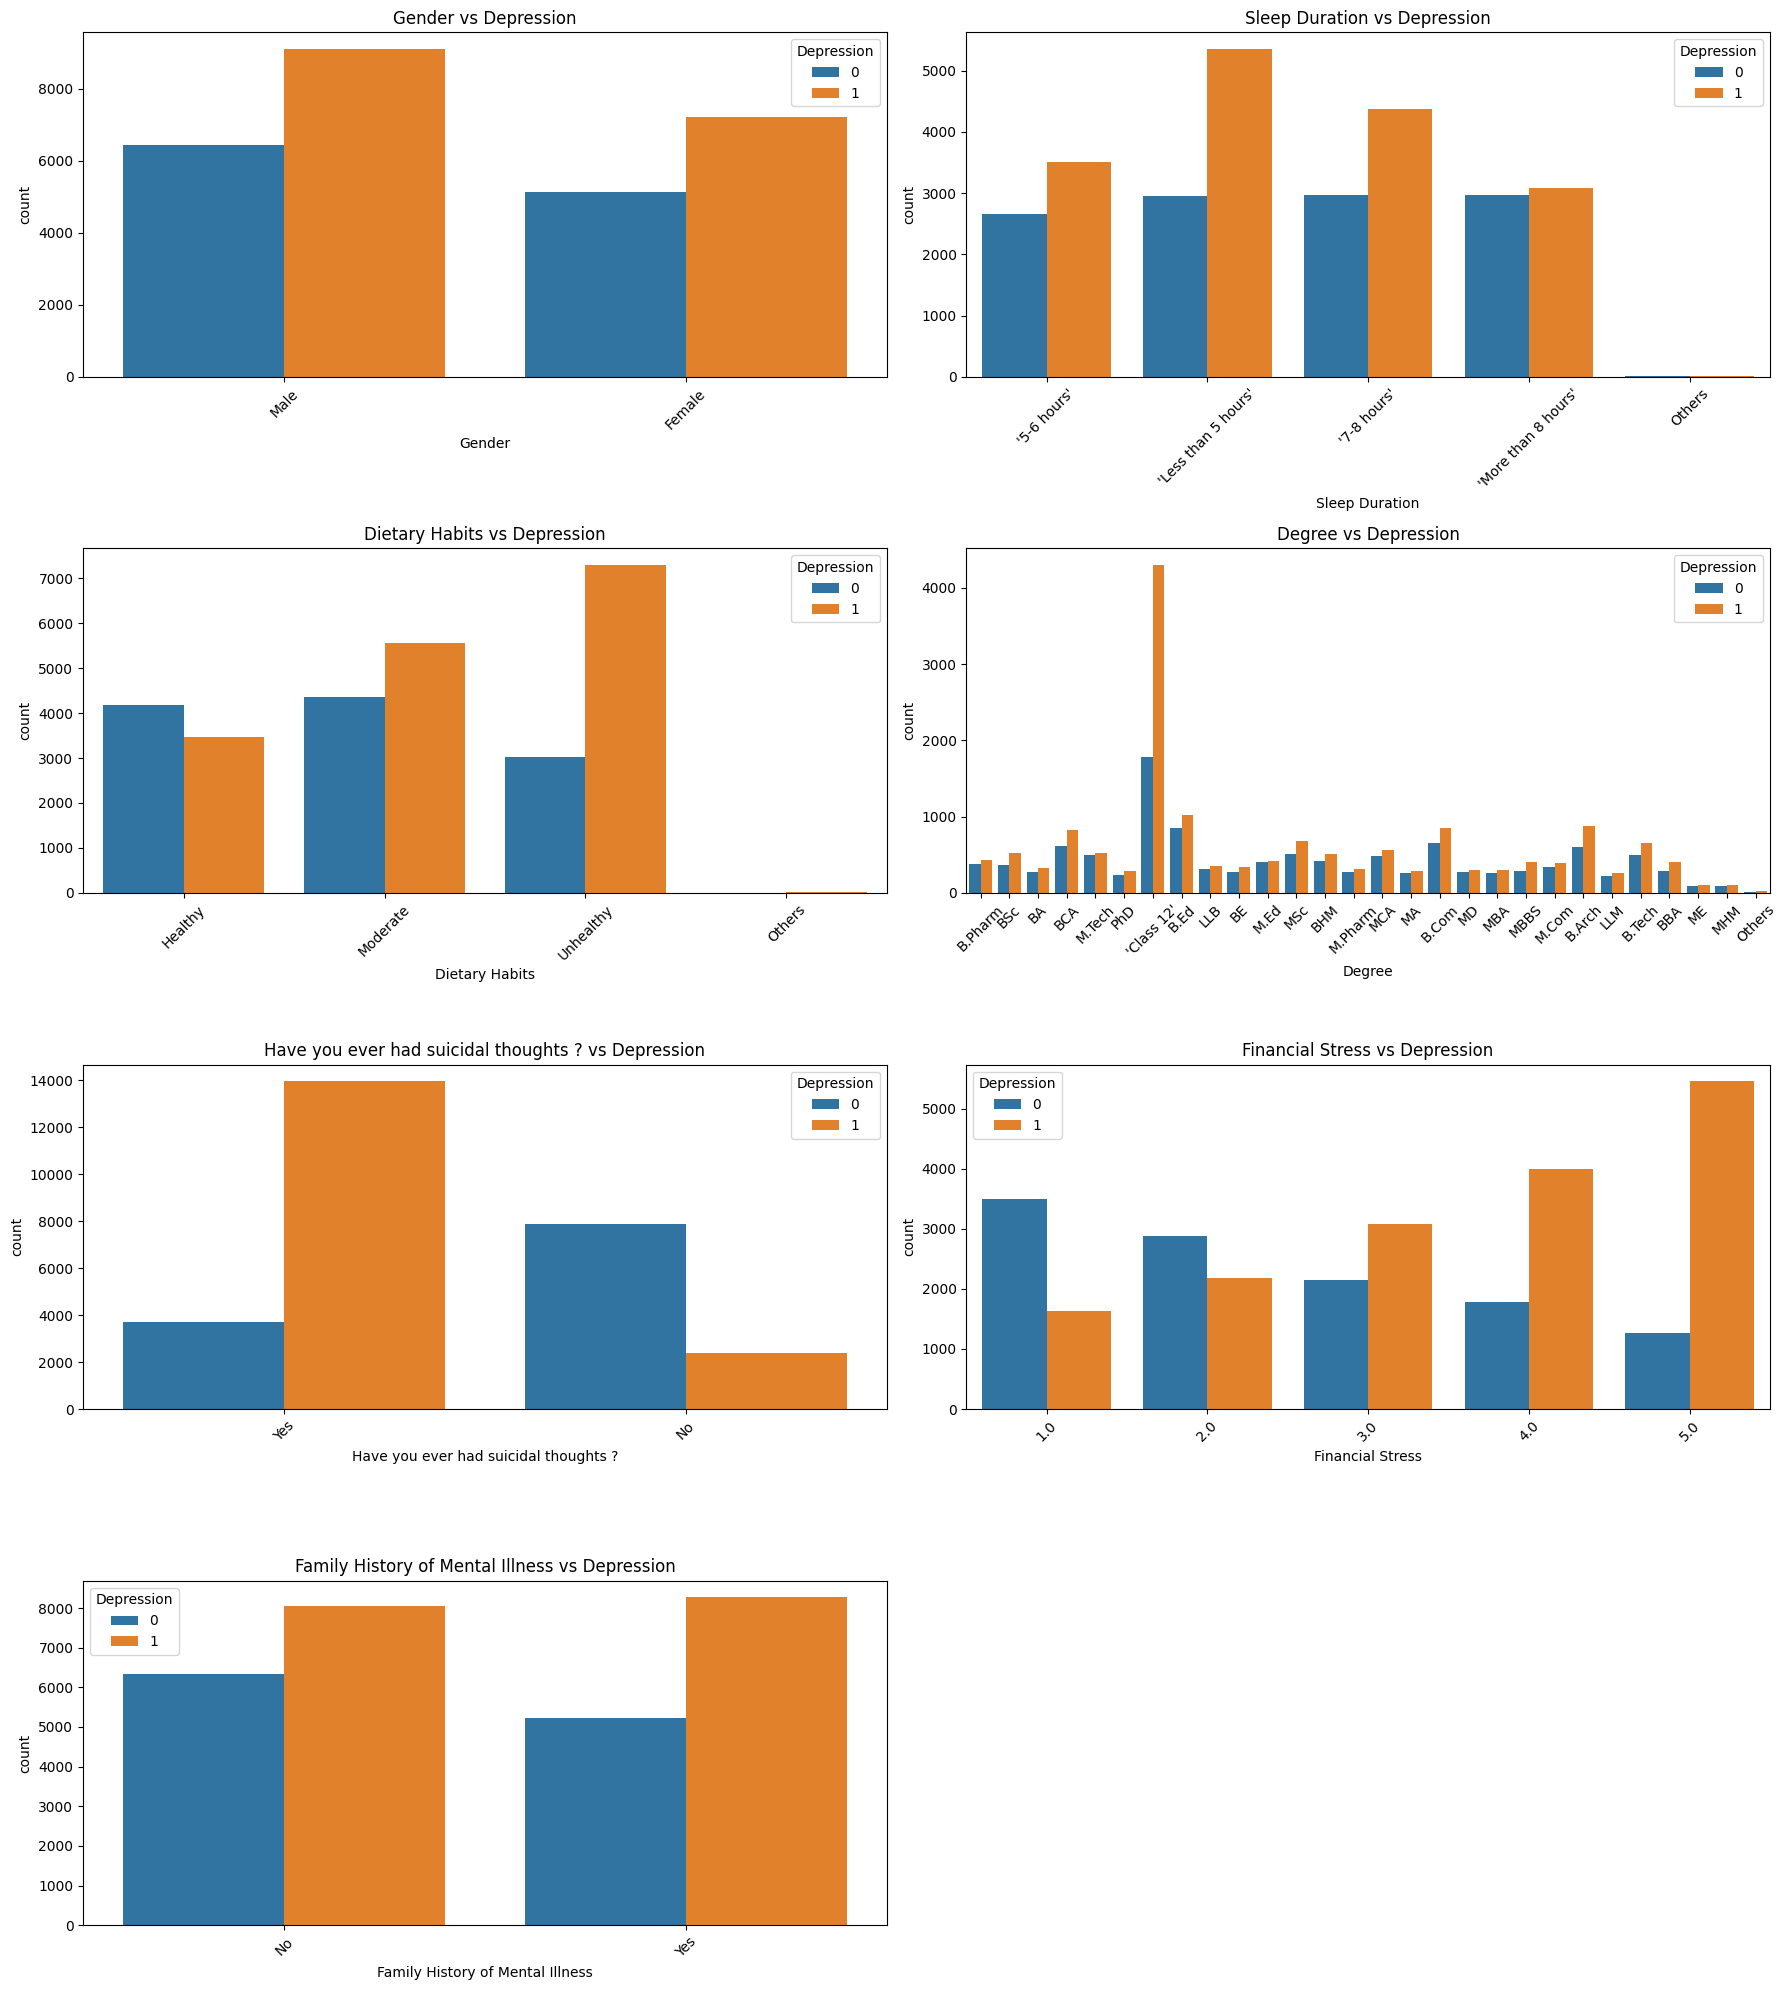

In [5]:
# List of categorical features to analyze vs Depression
categorical_features = ['Gender', 'Sleep Duration', 'Dietary Habits', 
                        'Degree', 'Have you ever had suicidal thoughts ?',
                        'Financial Stress', 'Family History of Mental Illness']

# Create count plots for each categorical feature against Depression
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, hue='Depression', ax=axes[i])
    axes[i].set_title(f'{feature} vs Depression')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplot
if len(categorical_features) < len(axes):
    for j in range(len(categorical_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [18]:
from scipy.stats import ttest_ind

numerical_cols = ['Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age']

for col in numerical_cols:
    group0 = df[df['Depression'] == 0][col].dropna()
    group1 = df[df['Depression'] == 1][col].dropna()
    stat, p = ttest_ind(group0, group1, equal_var=False)
    print(f'** T-test for {col} by Depression status:')
    print(f'   p-value = {p:.4f} {"(Significant)" if p < 0.05 else "(Not significant)"}\n')


** T-test for Academic Pressure by Depression status:
   p-value = 0.0000 (Significant)

** T-test for Study Satisfaction by Depression status:
   p-value = 0.0000 (Significant)

** T-test for Job Satisfaction by Depression status:
   p-value = 0.5779 (Not significant)

** T-test for Age by Depression status:
   p-value = 0.0000 (Significant)



In [16]:
from scipy.stats import chi2_contingency

categorical_cols = ['Gender', 'Sleep Duration', 'Dietary Habits', 
                    'Financial Stress', 'Have you ever had suicidal thoughts ?', 
                    'Family History of Mental Illness']

for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['Depression'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f'-- Chi-square test between {col} and Depression:')
    print(f'   p-value = {p:.4f} {"(Significant)" if p < 0.05 else "(Not significant)"}\n')



-- Chi-square test between Gender and Depression:
   p-value = 0.7737 (Not significant)

-- Chi-square test between Sleep Duration and Depression:
   p-value = 0.0000 (Significant)

-- Chi-square test between Dietary Habits and Depression:
   p-value = 0.0000 (Significant)

-- Chi-square test between Financial Stress and Depression:
   p-value = 0.0000 (Significant)

-- Chi-square test between Have you ever had suicidal thoughts ? and Depression:
   p-value = 0.0000 (Significant)

-- Chi-square test between Family History of Mental Illness and Depression:
   p-value = 0.0000 (Significant)



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Feature columns (based on earlier selection)
features = ['Gender', 'Age', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction',
            'Financial Stress', 'Sleep Duration', 'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']

# Target
target = 'Depression'

# Make a copy to avoid modifying original
data = df[features + [target]].copy()

# Encode categorical variables
cat_cols = data.select_dtypes(include='object').columns
le = LabelEncoder()

for col in cat_cols:
    data[col] = le.fit_transform(data[col].astype(str))

# Train-test split
X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(probability=True)
}

# Fit and evaluate
for name, model in models.items():
    print(f'\n📊 Model: {name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f'ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}')



📊 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2343
           1       0.84      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.82      5581
weighted avg       0.83      0.83      0.83      5581

ROC-AUC Score: 0.901

📊 Model: Random Forest
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2343
           1       0.82      0.82      0.82      3238

    accuracy                           0.79      5581
   macro avg       0.79      0.79      0.79      5581
weighted avg       0.79      0.79      0.79      5581

ROC-AUC Score: 0.868

📊 Model: SVM (RBF Kernel)
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      2343
           1       0.84      0.88      0.86      3238

    accuracy                           0.83      5581
   ma

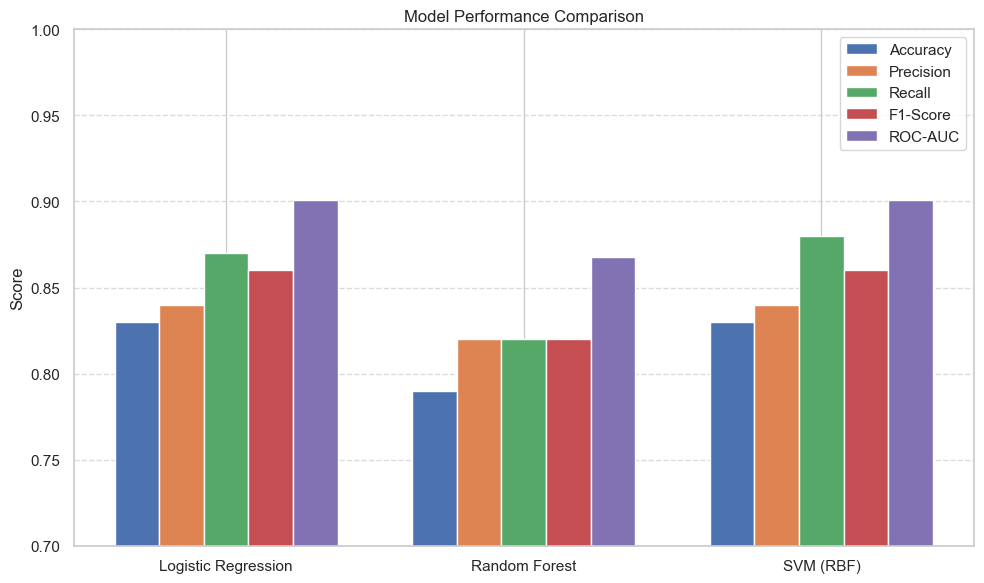

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Logistic Regression', 'Random Forest', 'SVM (RBF)']
accuracy = [0.83, 0.79, 0.83]
precision = [0.84, 0.82, 0.84]
recall = [0.87, 0.82, 0.88]
f1 = [0.86, 0.82, 0.86]
roc_auc = [0.901, 0.868, 0.901]

x = np.arange(len(models))  # label locations
width = 0.15  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width, precision, width, label='Precision')
rects3 = ax.bar(x, recall, width, label='Recall')
rects4 = ax.bar(x + width, f1, width, label='F1-Score')
rects5 = ax.bar(x + 2*width, roc_auc, width, label='ROC-AUC')

# Labels and Title
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


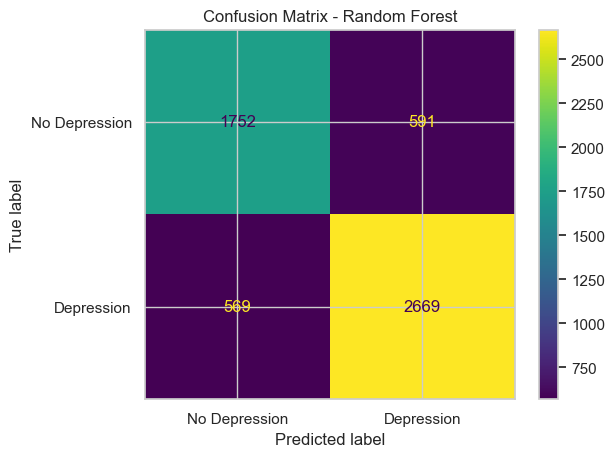

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Choose a model to visualize
model = models['Random Forest']
y_pred = model.predict(X_test)

# Plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix - Random Forest')
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_44116\3390291843.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, orient='h', palette='viridis')


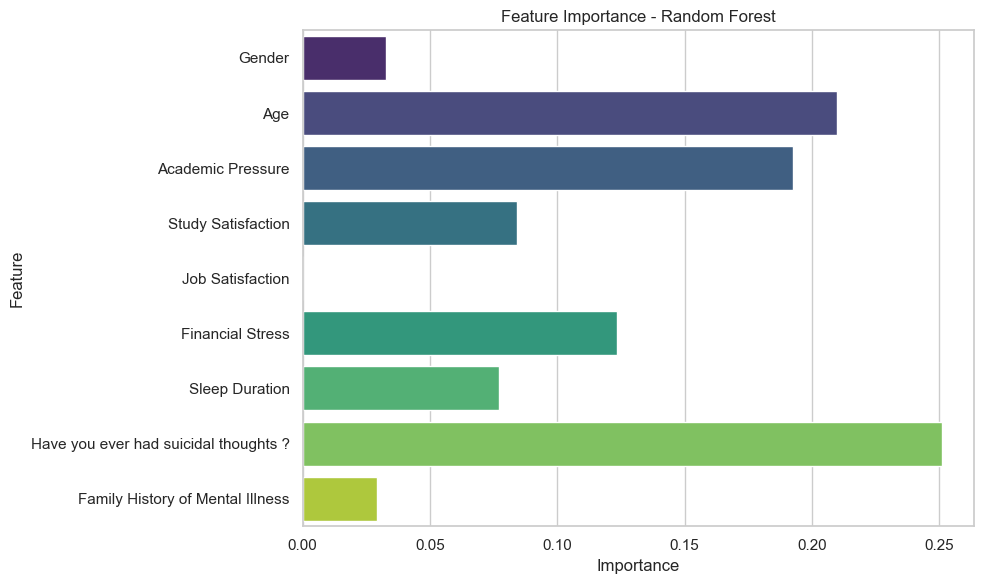

In [10]:
# Plot feature importances from Random Forest
importances = models['Random Forest'].feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, orient='h', palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

# Grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best F1 Score on Validation:", grid.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score on Validation: 0.8654736791094111
